In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from os import path

%matplotlib inline

In [57]:
mpl.rc('text', usetex=True)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='png')

In [3]:
mpl.rcParams['figure.dpi'] = 150

The LEC dependence of the observables is a ratio of quadratic functions. Below are functions that can compute observables given the LECs and the quadratic coefficients, along with gradients with respect to LECs.

In [4]:
def compute_idx_mat(n):
    one = np.ones(n)
    idx = np.arange(n)
    idx_rows, idx_cols = np.broadcast_arrays(idx[:, None], idx)
    idx_mat = np.dstack([idx_rows, idx_cols])
    return idx_mat

def p_sq_grad_mat(n):
    nrows = int(n*(n+1)/2)
    idx_mat = compute_idx_mat(n)
    idx_vec = idx_mat[np.triu_indices(n)]

    p_sq_grad = np.zeros((nrows, n))
    for i in range(n):
        p_sq_grad[:, i] = np.sum(idx_vec == i, axis=1)
    return p_sq_grad

def p_sq_idx_mat(n):
    idx_mat = compute_idx_mat(n)
    idx1, idx2 = np.triu_indices(idx_mat.shape[0])
    idx_mat_tri = idx_mat[idx1, idx2, :]
    test_mat = np.zeros((int(n*(n+1)/2), n), dtype=int)
    for i in range(n):
        mask = np.any(idx_mat_tri == i, axis=1)
        test_mat[mask, i] = np.arange(np.sum(mask), dtype=int)
    return test_mat

def p_sq_grad_mat_full(n):
    one = np.ones(n)
    p_sq_grad = np.zeros((n, n, n))
    for i in range(n):
        p_sq_grad[i, i] += one
        p_sq_grad[i, :, i] += one
    return p_sq_grad



In [5]:
def quadratic(x, A, b, c):
    R"""Computes a multivariate quadratic function.
    
    Parameters
    ----------
    x : array, shape = (p,)
        The input variables
    A : array, shape = (N, p, p)
        The quadratic coefficients
    b : array, shape = (N, p)
        The linear coefficients
    c : array, shape = (N,)
        The constant term
    
    Returns
    -------
    array, shape = (N,)
    """
    return np.einsum('...ij,i,j', A, x, x) + b @ x + c

def grad_quadratic(x, A, b, c):
    R"""Computes the gradient of a multivariate quadratic function.
    
    Parameters
    ----------
    x : array, shape = (p,)
        The input variables
    A : array, shape = (N, p, p)
        The quadratic coefficients
    b : array, shape = (N, p)
        The linear coefficients
    c : array, shape = (N,)
        The constant term
    
    Returns
    -------
    array, shape = (p, N)
    """
    At = np.swapaxes(A, -1, -2)
    return ((A + At) @ x + b).T

def quadratic_flat(x, A, b, c):
    R"""Computes a multivariate quadratic function.
    
    Parameters
    ----------
    x : array, shape = (p,)
        The input variables
    A : array, shape = (N, p(p+1)/2,)
        The quadratic coefficients
    b : array, shape = (N, p)
        The linear coefficients
    c : array, shape = (N,)
        The constant term
    
    Returns
    -------
    array, shape = (N,)
    """
    x = np.atleast_1d(x)
    x_sq = x[:, None] * x
    x_quad = x_sq[np.triu_indices_from(x_sq)]
    return A @ x_quad + b @ x + c

def grad_quadratic_flat(x, A, b, c):
    R"""Computes the gradient of a multivariate quadratic function.
    
    Parameters
    ----------
    x : array, shape = (N,p)
        The input variables
    A : array, shape = (N, p(p+1)/2)
        The quadratic coefficients
    b : array, shape = (N, p)
        The linear coefficients
    c : array, shape = (N,)
        The constant term
    
    Returns
    -------
    array, shape = (p, N)
    """
    x = np.atleast_1d(x)
    n = len(x)
    coeff_mat = p_sq_grad_mat(n)
    idx_mat = p_sq_idx_mat(n)
    x_sq_grad = coeff_mat * x[idx_mat]
    return (A @ x_sq_grad + b).T

def quad_ratio(x, An, bn, cn, Ad, bd, cd):
    R"""Computes the ratio of multivariate quadratic functions.
    
    Parameters
    ----------
    x : array, shape = (N,p)
        The input variables
    An : array, shape = (N, p, p)
        The quadratic coefficients of the numerator
    bn : array, shape = (N, p)
        The linear coefficients of the numerator
    cn : array, shape = (N,)
        The constant term of the numerator
    Ad : array, shape = (N, p, p)
        The quadratic coefficients of the denominator
    bd : array, shape = (N, p)
        The linear coefficients of the denominator
    cd : array, shape = (N,)
        The constant term of the denominator
    
    Returns
    -------
    array, shape = (N,)
    """
    return quadratic(x, An, bn, cn) / quadratic(x, Ad, bd, cd)

def grad_quad_ratio(x, An, bn, cn, Ad, bd, cd):
    R"""Computes the gradient of the ratio of multivariate quadratic functions.
    
    Parameters
    ----------
    x : array, shape = (N,p)
        The input variables
    An : array, shape = (N, p, p)
        The quadratic coefficients of the numerator
    bn : array, shape = (N, p)
        The linear coefficients of the numerator
    cn : array, shape = (N,)
        The constant term of the numerator
    Ad : array, shape = (N, p, p)
        The quadratic coefficients of the denominator
    bd : array, shape = (N, p)
        The linear coefficients of the denominator
    cd : array, shape = (N,)
        The constant term of the denominator
    
    Returns
    -------
    array, shape = (p, N)
    """
    fn = quadratic(x, An, bn, cn)
    grad_fn = grad_quadratic(x, An, bn, cn)
    fd = quadratic(x, Ad, bd, cd)
    grad_fd = grad_quadratic(x, Ad, bd, cd)
    return grad_fn / fd - fn / fd**2 * grad_fd

In [6]:
A = np.array([[2, 1], [0, 1]])
b = np.array([2, 3])
c = -1.2

A2 = np.array([[-1.0, 3], [0, 5]])
b2 = np.array([-1.0, 1])
c2 = 2.3

Make sure I didn't mess up

In [7]:
check_grad(quadratic, grad_quadratic, [-10, 30], A, b, c)

0.0

In [8]:
A[np.triu_indices_from(A)]

array([2, 1, 1])

In [9]:
check_grad(quadratic_flat, grad_quadratic_flat, [1, 3], A[np.triu_indices_from(A)], b, c)

0.0

In [10]:
check_grad(quad_ratio, grad_quad_ratio, [-10, 3], A, b, c, A2, b2, c2)

4.4023120448427e-09

How to fill in an (N,p,p) matrix for the quadratic terms when the initial data is an (N, p(p+1)/2) array.

In [11]:
n = 3
M = np.zeros((2, n, n))
aa = np.arange(n*(n+1)/2)

row_idx, col_idx = np.triu_indices(n)
print(M[:, row_idx, col_idx].shape)
M[:, row_idx, col_idx] = aa
M

(2, 6)


array([[[0., 1., 2.],
        [0., 3., 4.],
        [0., 0., 5.]],

       [[0., 1., 2.],
        [0., 3., 4.],
        [0., 0., 5.]]])

## Testing Linearity Assumption

What if we expand about the best parameter values? If it is linear in a sufficiently large region, then this will make experimental design much easier.

In [12]:
def create_linear_func(x0, An, bn, cn, Ad, bd, cd):
    f0 = quad_ratio(x0, An, bn, cn, Ad, bd, cd)
    grad_f0 = grad_quad_ratio(x0, An, bn, cn, Ad, bd, cd)
    def _lin_func(x):
        return f0 + (x - x0) @ grad_f0
    return _lin_func

In [13]:
x0 = np.array([1, 1])
lin_quad = create_linear_func(x0, A, b, c, A2, b2, c2)
np.random.seed(1)
x_all = stats.norm(loc=x0, scale=0.1).rvs((100, 2))

f_linearized = lin_quad(x_all)
f_true = np.array([quad_ratio(x_i, A, b, c, A2, b2, c2) for x_i in x_all])

f_lin0 = lin_quad(x0)
f_true0 = quad_ratio(x0, A, b, c, A2, b2, c2)

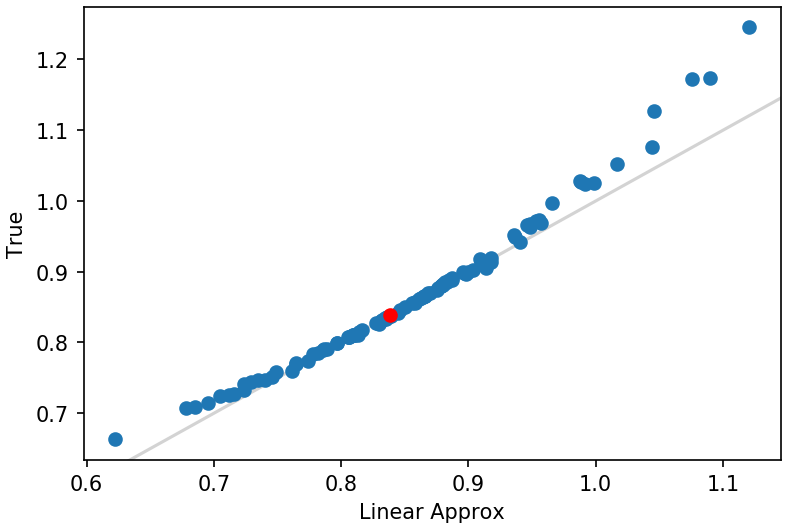

In [14]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots()
ax.plot(f_linearized, f_true, ls='', marker='o')
ax.plot(f_lin0, f_true0, ls='', marker='o', c='r')

# Will not update limits
col = LineCollection([np.array([[-10, 10], [-10, 10]]).T], colors='lightgray')
ax.add_collection(col, autolim=False)

ax.set_xlabel('Linear Approx')
ax.set_ylabel('True');

Should like on the $y=x$ line if all is going well. Should now test with real data. The extent to which it works will depend on the size of the numerator's quadratic terms, and how much influence the denominator has.

In [15]:
obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df = pd.read_csv(obs_file, dtype={'observable': str})

In [16]:
df

,omegalab [MeV],thetalab [deg],observable,nucleon,order,is_numerator,A,B1,B2,B3,...,C33,C34,C35,C36,C44,C45,C46,C55,C56,C66
0,5.0,1,crosssection,proton,3,1,23.550624,-0.001971,-0.001971,4.278199e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.0,1,crosssection,proton,3,0,1.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5.0,5,crosssection,proton,3,1,23.463893,-0.001963,-0.001963,4.271897e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5.0,5,crosssection,proton,3,0,1.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.0,10,crosssection,proton,3,1,23.195600,-0.001941,-0.001941,4.251508e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284747,340.0,170,2Zp,neutron,4,0,1539.171610,22.347716,-22.350937,4.854397e+01,...,1.775510,-3.452411,3.354500,-3.452411,1.775510,-3.452411,3.354500,1.726380,-3.355539,1.726380
284748,340.0,175,2Zp,neutron,4,1,1404.223925,36.547947,-36.547947,2.941353e+01,...,0.006110,0.012220,-0.012198,-0.012198,0.006110,-0.012198,-0.012198,0.006088,0.012177,0.006088
284749,340.0,175,2Zp,neutron,4,0,1535.901865,22.339037,-22.339236,4.810882e+01,...,1.735146,-3.445853,3.421456,-3.445853,1.735146,-3.445853,3.421456,1.722937,-3.421521,1.722937
284750,340.0,180,2Zp,neutron,4,1,1402.767299,36.552870,-36.552870,2.930796e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
omega_lab_unique = df['omegalab [MeV]'].unique()
degrees_lab_unique = df['thetalab [deg]'].unique()
observables_unique = df['observable'].unique()
n_omega = len(omega_lab_unique)
n_angle = len(degrees_lab_unique)

In [18]:
from sklearn.utils.extmath import cartesian
X = cartesian([omega_lab_unique, degrees_lab_unique])
X

array([[  5.,   1.],
       [  5.,   5.],
       [  5.,  10.],
       ...,
       [340., 170.],
       [340., 175.],
       [340., 180.]])

In [19]:
sd_exp = 0.05  # Guess from fig A.9 from Martel Thesis

In [20]:
from compton import ComptonObservable, proton_pol_vec_mean, neutron_pol_vec_mean, \
    proton_pol_vec_std, neutron_pol_vec_std

proton_pol_cov = np.diag(proton_pol_vec_std)
neutron_pol_cov = np.diag(neutron_pol_vec_std)

In [21]:
groups = df.groupby(['observable', 'nucleon', 'order'])
compton_obs = {}
for (obs, nucleon, order), index in groups.groups.items():
#     print(obs, nucleon, order)
    df_i = df.loc[index]
    df_n = df_i[df_i['is_numerator'] == 1]
    df_d = df_i[df_i['is_numerator'] == 0]
    lin_vec = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    quad_vec = [col for col in df_i.columns if col[0] == 'C']
    cov_p = proton_pol_cov if nucleon == 'proton' else neutron_pol_cov
    obs_kwargs = dict(
        omega_lab=df_n['omegalab [MeV]'].values,
        degrees_lab=df_n['thetalab [deg]'].values,
        quad_n=df_n[quad_vec].values,
        lin_n=df_n[lin_vec].values,
        const_n=df_n['A'].values,
        quad_d=df_d[quad_vec].values,
        lin_d=df_d[lin_vec].values,
        const_d=df_d['A'].values,
        name=obs if obs != 'crosssection' else 'dsg',
        order=order,
        nucleon=nucleon,
        cov_p=cov_p,
    )
    p0 = proton_pol_vec_mean if nucleon == 'proton' else neutron_pol_vec_mean
#     print(len(p0))
    compton_obs[obs, nucleon, order, 'nonlinear'] = ComptonObservable(**obs_kwargs)
    
    cov_data = sd_exp**2 * np.eye(len(df_n))
    if obs == 'crosssection':
        pred_i = compton_obs[obs, nucleon, order, 'nonlinear'](p0)
        cov_data *= pred_i[:, None] * pred_i
    compton_obs[obs, nucleon, order, 'linear'] = ComptonObservable(**obs_kwargs, p0=p0, cov_data=cov_data)

In [22]:
compton_obs

{('1X', 'neutron', 3, 'nonlinear'): 1X(3, neutron),
 ('1X',
  'neutron',
  3,
  'linear'): 1X(3, neutron) about [11.55  3.65 -4.    1.3  -0.1   2.4 ],
 ('1X', 'neutron', 4, 'nonlinear'): 1X(4, neutron),
 ('1X',
  'neutron',
  4,
  'linear'): 1X(4, neutron) about [11.55  3.65 -4.    1.3  -0.1   2.4 ],
 ('1X', 'proton', 3, 'nonlinear'): 1X(3, proton),
 ('1X',
  'proton',
  3,
  'linear'): 1X(3, proton) about [10.65  3.15 -1.1   2.2  -0.4   1.9 ],
 ('1X', 'proton', 4, 'nonlinear'): 1X(4, proton),
 ('1X',
  'proton',
  4,
  'linear'): 1X(4, proton) about [10.65  3.15 -1.1   2.2  -0.4   1.9 ],
 ('1Xp', 'neutron', 3, 'nonlinear'): 1Xp(3, neutron),
 ('1Xp',
  'neutron',
  3,
  'linear'): 1Xp(3, neutron) about [11.55  3.65 -4.    1.3  -0.1   2.4 ],
 ('1Xp', 'neutron', 4, 'nonlinear'): 1Xp(4, neutron),
 ('1Xp',
  'neutron',
  4,
  'linear'): 1Xp(4, neutron) about [11.55  3.65 -4.    1.3  -0.1   2.4 ],
 ('1Xp', 'proton', 3, 'nonlinear'): 1Xp(3, proton),
 ('1Xp',
  'proton',
  3,
  'linear'): 1Xp

In [23]:
n_pol = len(proton_pol_vec_mean)
np.random.seed(1)
p_proton = stats.norm(proton_pol_vec_mean, proton_pol_vec_std).rvs((200, n_pol))
p_neutron = stats.norm(neutron_pol_vec_mean, neutron_pol_vec_std).rvs((200, n_pol))
print(p_proton.shape)

(200, 6)


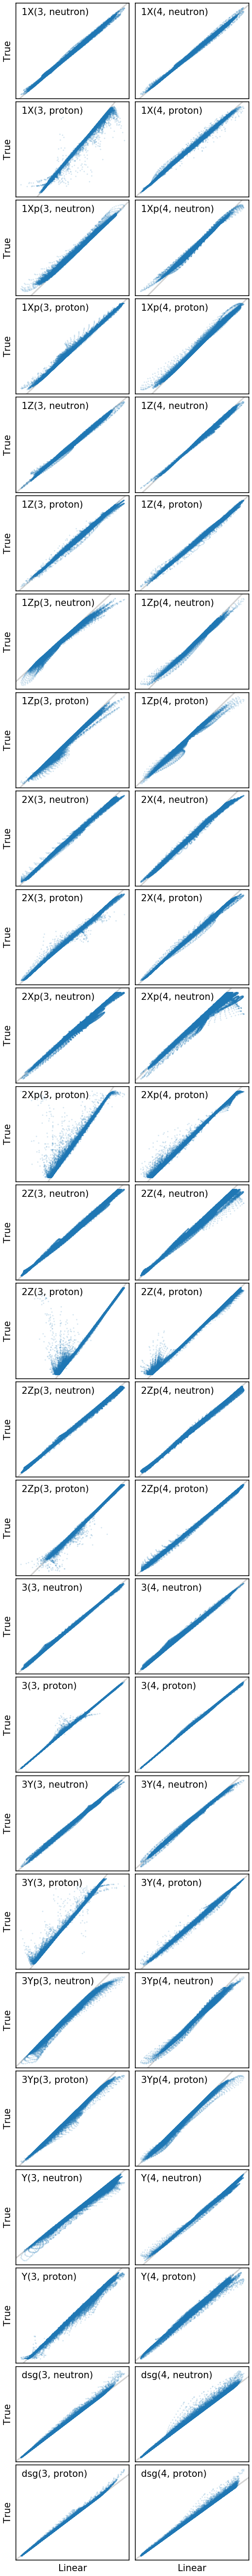

In [24]:
ncols = 2
nrows = int(np.ceil(len(groups.groups.items())/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 1.5*nrows))
for i, (obs, nucleon, order) in enumerate(groups.groups.keys()):
    ax = axes.ravel()[i]
    p = p_proton if nucleon == 'proton' else p_neutron
    pred = np.array([compton_obs[obs, nucleon, order, 'nonlinear'](p_i) for p_i in p])
    pred_lin = np.array([compton_obs[obs, nucleon, order, 'linear'](p_i) for p_i in p])
    ax.plot(pred_lin.ravel(), pred.ravel(), ls='', marker='o', markersize=0.1)
#     ax.set_title(compton_obs[obs, nucleon, order, 'nonlinear'])
    ax.text(0.05, 0.95, compton_obs[obs, nucleon, order, 'nonlinear'], transform=ax.transAxes,
           ha='left', va='top', bbox=dict(boxstyle='round', alpha=0))
    ax.set_xticks([])
    ax.set_yticks([])
#     print(compton_obs[obs, nucleon, order, 'nonlinear'].omega_lab.shape,
#           compton_obs[obs, nucleon, order, 'nonlinear'].degrees_lab.shape)
    
    bound = 1.5*np.max([np.abs(pred), np.abs(pred_lin)])
    col = LineCollection([np.array([[-bound, bound], [-bound, bound]]).T], colors='lightgray')
    ax.add_collection(col, autolim=False)
    if i % 2 == 0:
        ax.set_ylabel('True')

axes[-1, 0].set_xlabel('Linear')
axes[-1, 1].set_xlabel('Linear')
fig.tight_layout(h_pad=0, w_pad=0.3)
fig.savefig('figures/true_vs_linear_observables')

In [25]:
sp.special.comb(2738, 3)

3417221136.0

In [26]:
from itertools import combinations, product

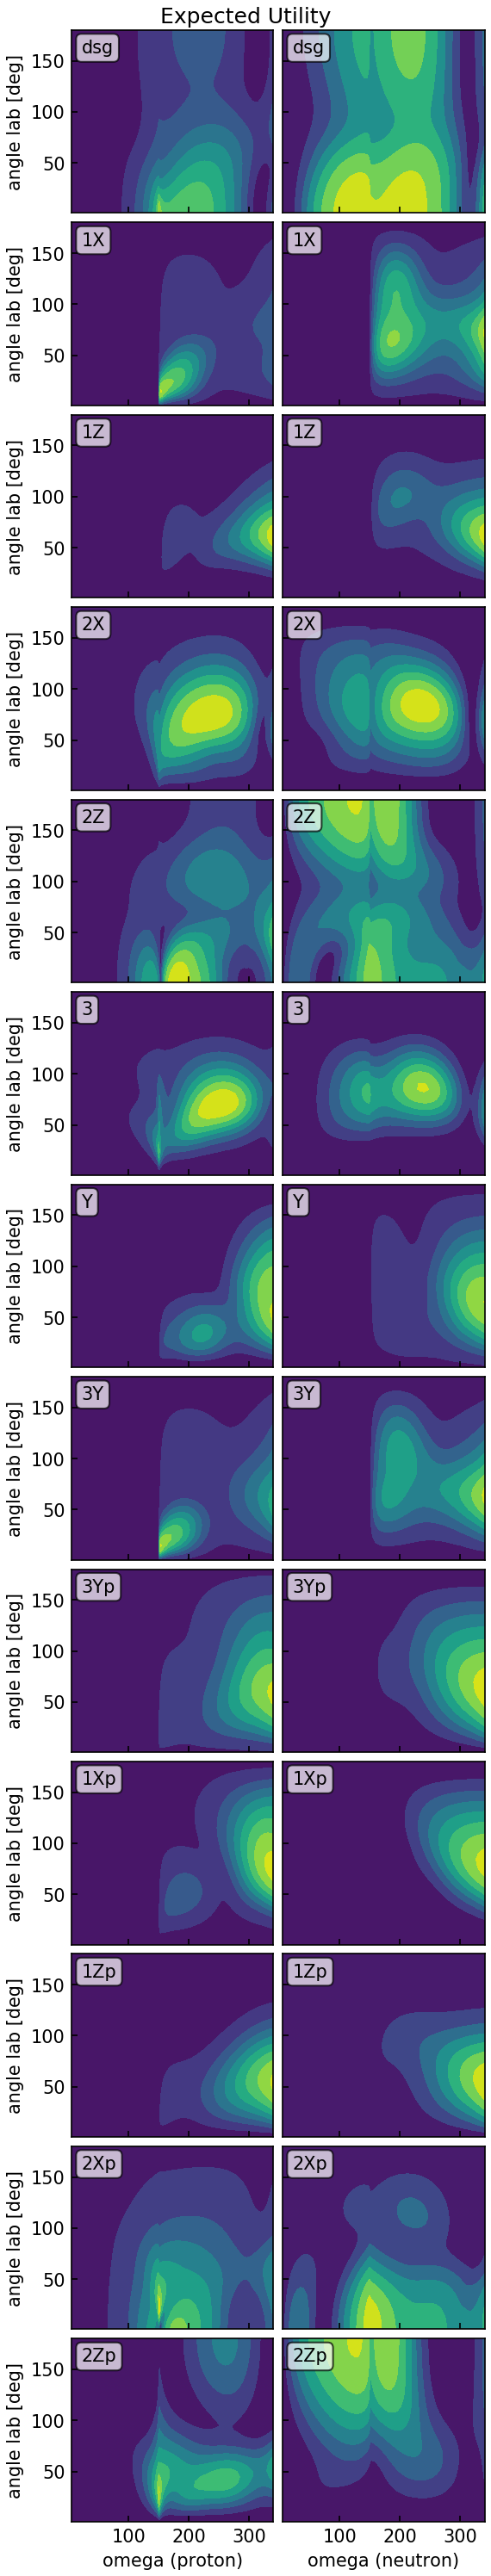

In [27]:
# obs_i = 'crosssection'
# nucleon_i = 'proton'
util_dict_no_trunc = {}

fig, axes = plt.subplots(len(observables_unique), 2, figsize=(4, 20), sharex=True, sharey=True)
for i, obs_i in enumerate(observables_unique):
    for j, nucleon_j in enumerate(['proton', 'neutron']):
        ax = axes[i, j]
        order_i = 4
        compton_i = compton_obs[obs_i, nucleon_j, order_i, 'linear']
#         n_data = len(compton_i.quad_n)
        n_data = compton_i.n_data
        combs_i = np.asarray(list(combinations(range(n_data), 1)))
        util_i = np.zeros(combs_i.shape, dtype=float)
        for k, idx_k in enumerate(combs_i):
            util_i[k] = compton_i.utility_linear(idx_k)
        util_dict_no_trunc[obs_i, nucleon_j] = util_i
        ax.contourf(omega_lab_unique, degrees_lab_unique, util_i.reshape(n_omega, n_angle).T)
        text = obs_i
        if obs_i == 'crosssection':
            text = 'dsg'
        ax.text(
            0.05, 0.95, text, transform=ax.transAxes,
            bbox=dict(facecolor='w', boxstyle='round', alpha=0.7), ha='left', va='top')
        if i == len(observables_unique)-1:
            ax.set_xlabel(f'omega ({nucleon_j})')
        if j == 0:
            ax.set_ylabel('angle lab [deg]')
        ax.tick_params(direction='in')

fig.suptitle('Expected Utility', y=1.)
fig.tight_layout(h_pad=0, w_pad=0.5)
fig.savefig('figures/expected_utility_no_truncation')

In [28]:
util_i

array([[-8.51279326],
       [-8.51279202],
       [-8.51278993],
       ...,
       [-8.21191597],
       [-8.21166819],
       [-8.21158666]])

Text(0.05, 0.9, '2Zp')

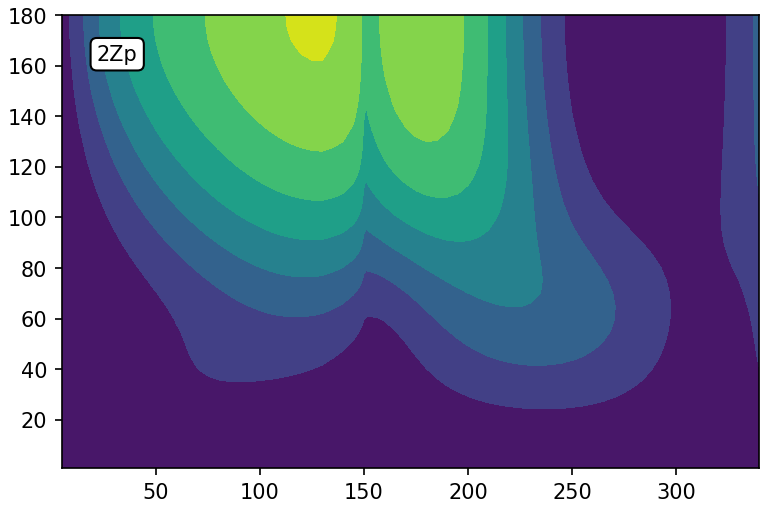

In [29]:
fig, ax = plt.subplots()
ax.contourf(omega_lab_unique, degrees_lab_unique, util_i.reshape(n_omega, n_angle).T)
ax.text(0.05, 0.9, obs_i, transform=ax.transAxes, bbox=dict(facecolor='w', boxstyle='round'))

In [30]:
from compton import RBFJump, expansion_parameter_transfer_cm, mass_proton, order_transition

breakdown = 650
# Fourth order is complete at low energy, so omitted is 5
# But it is not complete at high energy, so it goes to 2
omitted_order = order_transition(5, 2, X[:, 0])
Q = expansion_parameter_transfer_cm(X, breakdown, mass=mass_proton)
Q_sum = np.zeros((Q.shape[0], Q.shape[0]))
for i in range(100):
    Qi = Q**(omitted_order+i)
    Q_sum += Qi[:, None] * Qi
    
corr_mat = np.eye(Q.shape[0])
R_mat = Q_sum * corr_mat

In [31]:
Q_sum.shape

(2738, 2738)

In [32]:
Q_sum

array([[2.78830678e-07, 2.78830678e-07, 2.78830678e-07, ...,
        6.71586775e-04, 6.73298127e-04, 6.73867897e-04],
       [2.78830678e-07, 2.78830678e-07, 2.78830678e-07, ...,
        6.71586775e-04, 6.73298127e-04, 6.73867897e-04],
       [2.78830678e-07, 2.78830678e-07, 2.78830678e-07, ...,
        6.71586775e-04, 6.73298127e-04, 6.73867897e-04],
       ...,
       [6.71586775e-04, 6.71586775e-04, 6.71586775e-04, ...,
        2.33637091e+02, 2.50826320e+02, 2.56866559e+02],
       [6.73298127e-04, 6.73298127e-04, 6.73298127e-04, ...,
        2.50826320e+02, 2.69526505e+02, 2.76100018e+02],
       [6.73867897e-04, 6.73867897e-04, 6.73867897e-04, ...,
        2.56866559e+02, 2.76100018e+02, 2.82861772e+02]])

In [33]:
R_mat

array([[2.78830678e-07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.78830678e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.78830678e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.33637091e+02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.69526505e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.82861772e+02]])

In [34]:
groups = df.groupby(['observable', 'nucleon', 'order'])
compton_obs_trunc = {}
for (obs, nucleon, order), index in groups.groups.items():
    if order != 4:
        continue
#     print(obs, nucleon, order)
    df_i = df.loc[index]
    df_n = df_i[df_i['is_numerator'] == 1]
    df_d = df_i[df_i['is_numerator'] == 0]
    lin_vec = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    quad_vec = [col for col in df_i.columns if col[0] == 'C']
    cov_p = proton_pol_cov if nucleon == 'proton' else neutron_pol_cov
    obs_kwargs = dict(
        omega_lab=df_n['omegalab [MeV]'].values,
        degrees_lab=df_n['thetalab [deg]'].values,
        quad_n=df_n[quad_vec].values,
        lin_n=df_n[lin_vec].values,
        const_n=df_n['A'].values,
        quad_d=df_d[quad_vec].values,
        lin_d=df_d[lin_vec].values,
        const_d=df_d['A'].values,
        name=obs if obs != 'crosssection' else 'dsg',
        order=order,
        nucleon=nucleon,
        cov_p=cov_p,
    )
    p0 = proton_pol_vec_mean if nucleon == 'proton' else neutron_pol_vec_mean
    compton_obs_nonlinear = ComptonObservable(**obs_kwargs)
    
    cov_data = sd_exp**2 * np.eye(len(df_n))
    if obs == 'crosssection':
        pred_i = compton_obs_nonlinear(p0)
        cov_data *= pred_i[:, None] * pred_i
        R_mat = pred_i[:, None] * pred_i * R_mat
    cov_data += R_mat
    compton_obs_trunc[obs, nucleon, order, 'linear'] = ComptonObservable(**obs_kwargs, p0=p0, cov_data=cov_data)

In [35]:
compton_obs_trunc

{('1X',
  'neutron',
  4,
  'linear'): 1X(4, neutron) about [11.55  3.65 -4.    1.3  -0.1   2.4 ],
 ('1X',
  'proton',
  4,
  'linear'): 1X(4, proton) about [10.65  3.15 -1.1   2.2  -0.4   1.9 ],
 ('1Xp',
  'neutron',
  4,
  'linear'): 1Xp(4, neutron) about [11.55  3.65 -4.    1.3  -0.1   2.4 ],
 ('1Xp',
  'proton',
  4,
  'linear'): 1Xp(4, proton) about [10.65  3.15 -1.1   2.2  -0.4   1.9 ],
 ('1Z',
  'neutron',
  4,
  'linear'): 1Z(4, neutron) about [11.55  3.65 -4.    1.3  -0.1   2.4 ],
 ('1Z',
  'proton',
  4,
  'linear'): 1Z(4, proton) about [10.65  3.15 -1.1   2.2  -0.4   1.9 ],
 ('1Zp',
  'neutron',
  4,
  'linear'): 1Zp(4, neutron) about [11.55  3.65 -4.    1.3  -0.1   2.4 ],
 ('1Zp',
  'proton',
  4,
  'linear'): 1Zp(4, proton) about [10.65  3.15 -1.1   2.2  -0.4   1.9 ],
 ('2X',
  'neutron',
  4,
  'linear'): 2X(4, neutron) about [11.55  3.65 -4.    1.3  -0.1   2.4 ],
 ('2X',
  'proton',
  4,
  'linear'): 2X(4, proton) about [10.65  3.15 -1.1   2.2  -0.4   1.9 ],
 ('2Xp',
  '

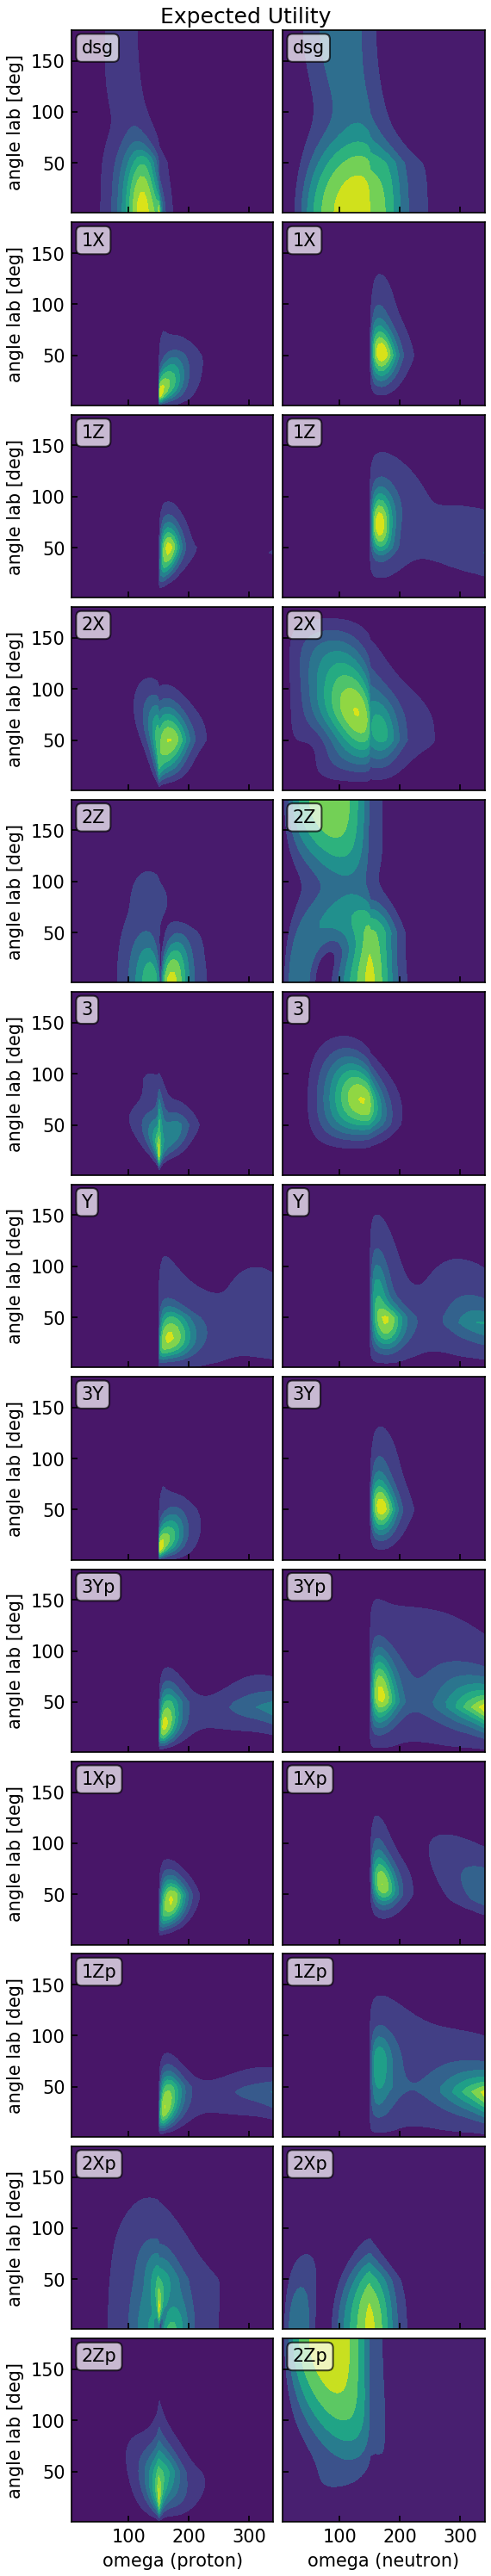

In [36]:
util_dict_trunc = {}

fig, axes = plt.subplots(len(observables_unique), 2, figsize=(4, 20), sharex=True, sharey=True)
for i, obs_i in enumerate(observables_unique):
    for j, nucleon_j in enumerate(['proton', 'neutron']):
        ax = axes[i, j]
        order_i = 4
        compton_i = compton_obs_trunc[obs_i, nucleon_j, order_i, 'linear']
        combs_i = np.asarray(list(combinations(range(n_data), 1)))
        util_i = np.zeros(combs_i.shape, dtype=float)
        n_data = len(compton_i.quad_n)
        for k, idx_k in enumerate(combs_i):
            util_i[k] = compton_i.utility_linear(idx_k)
        util_dict_trunc[obs_i, nucleon_j] = util_i
        ax.contourf(omega_lab_unique, degrees_lab_unique, util_i.reshape(n_omega, n_angle).T)
        text = obs_i
        if obs_i == 'crosssection':
            text = 'dsg'
        ax.text(
            0.05, 0.95, text, transform=ax.transAxes,
            bbox=dict(facecolor='w', boxstyle='round', alpha=0.7), ha='left', va='top')
        if i == len(observables_unique)-1:
            ax.set_xlabel(f'omega ({nucleon_j})')
        if j == 0:
            ax.set_ylabel('angle lab [deg]')
        ax.tick_params(direction='in')

fig.suptitle('Expected Utility', y=1.)
fig.tight_layout(h_pad=0, w_pad=0.5)
fig.savefig('figures/expected_utility_truncation')

/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


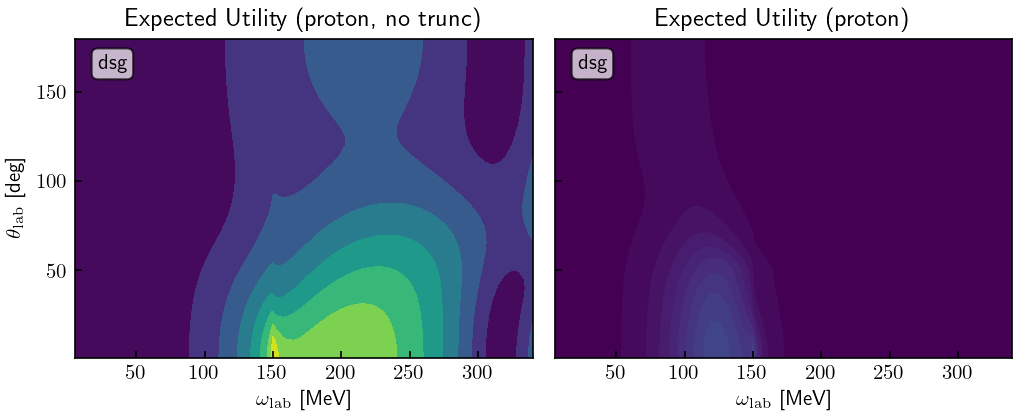

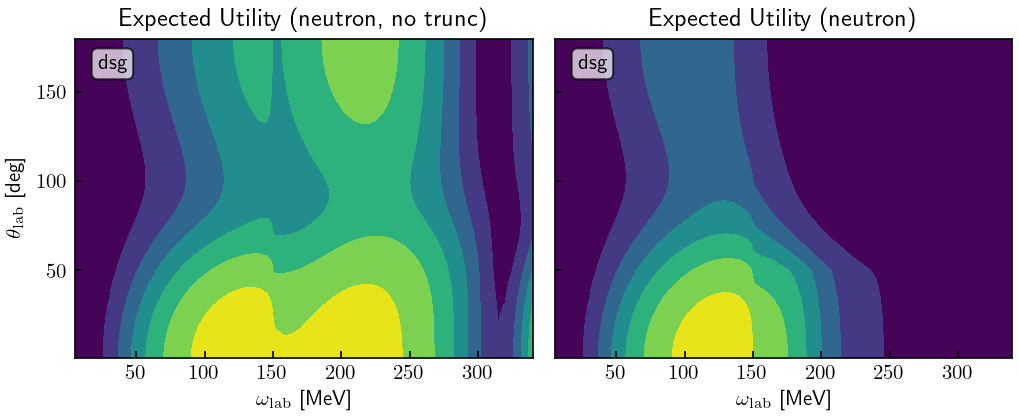

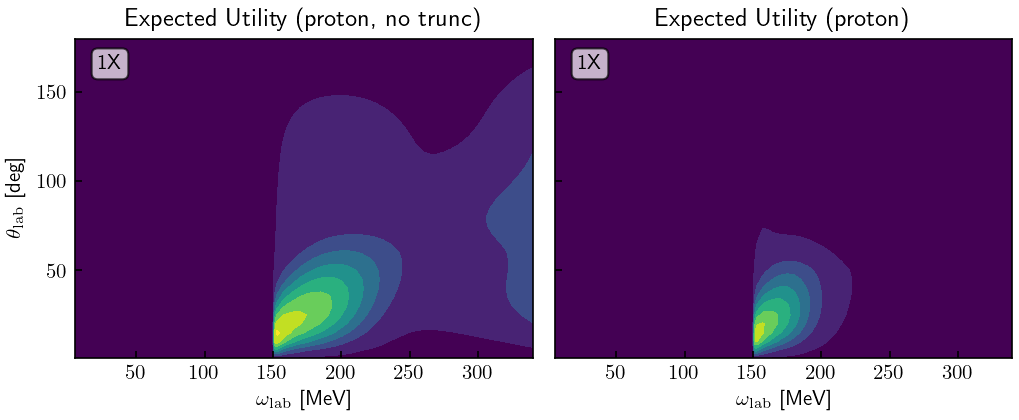

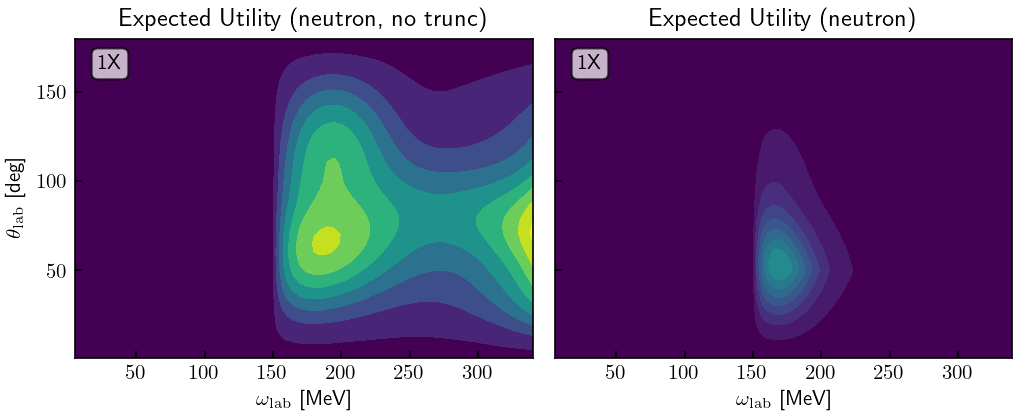

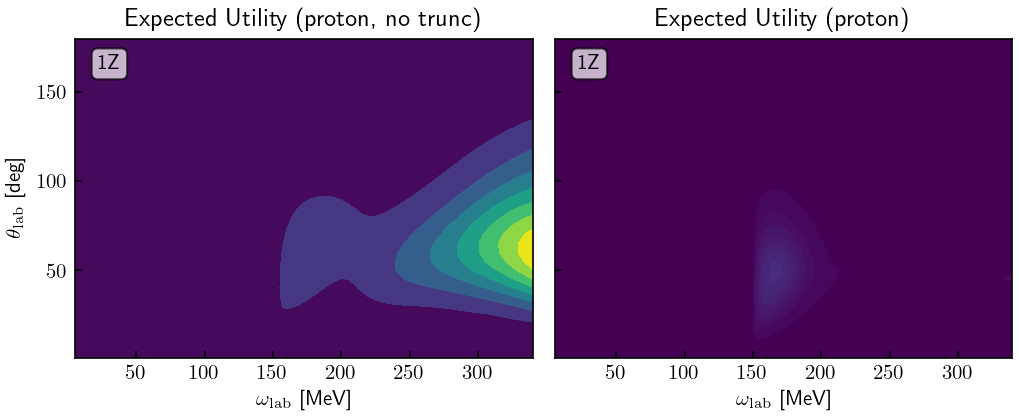

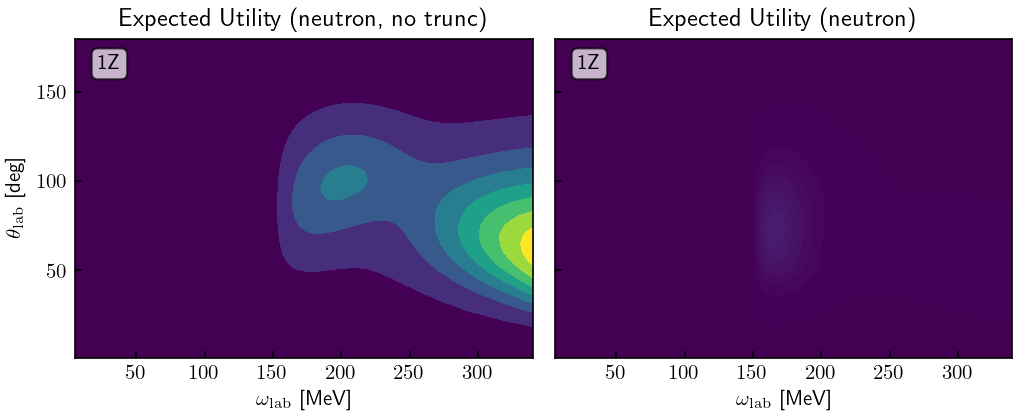

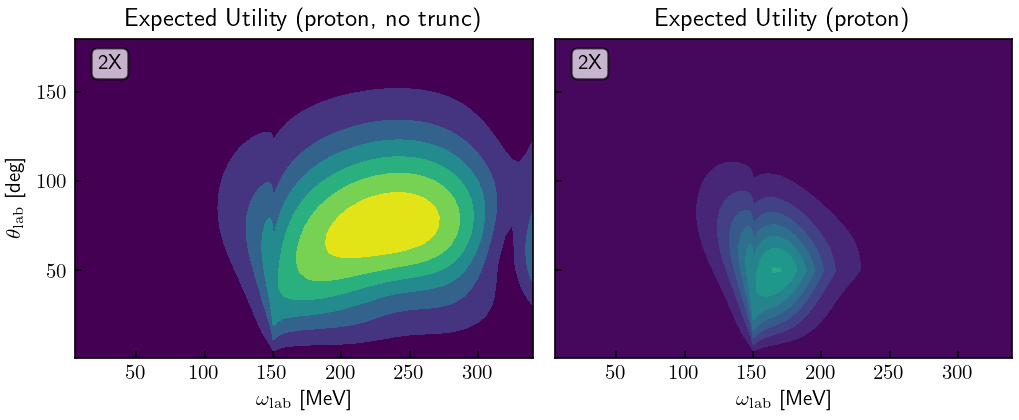

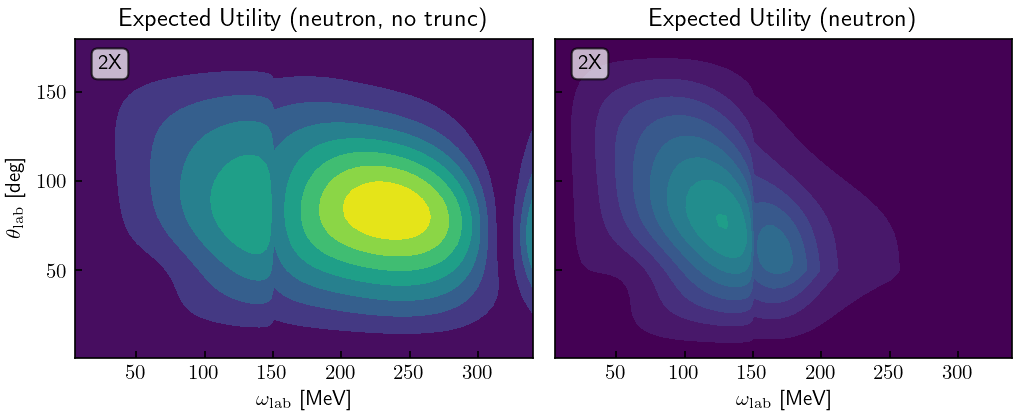

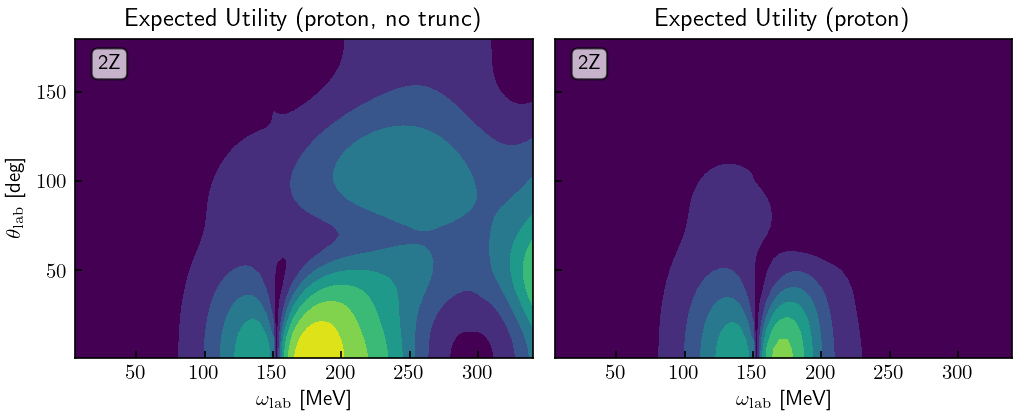

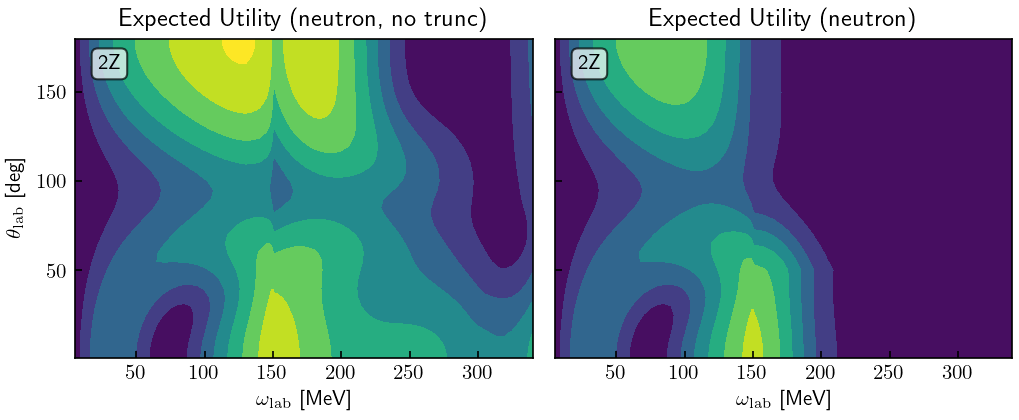

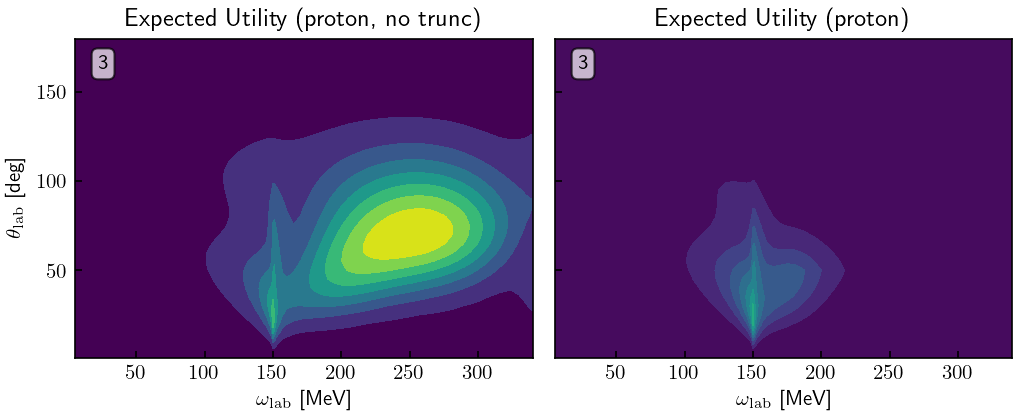

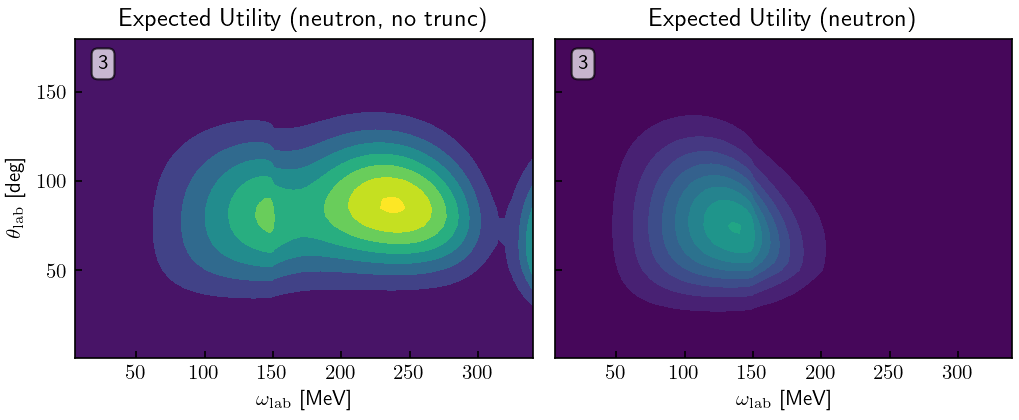

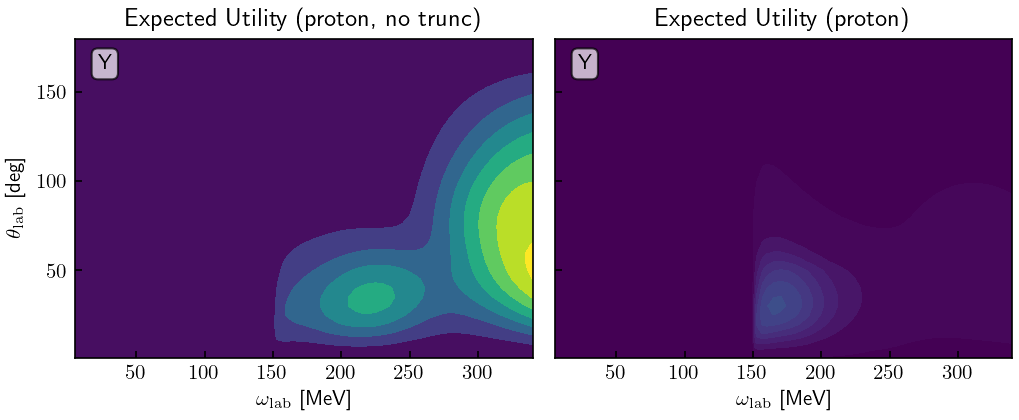

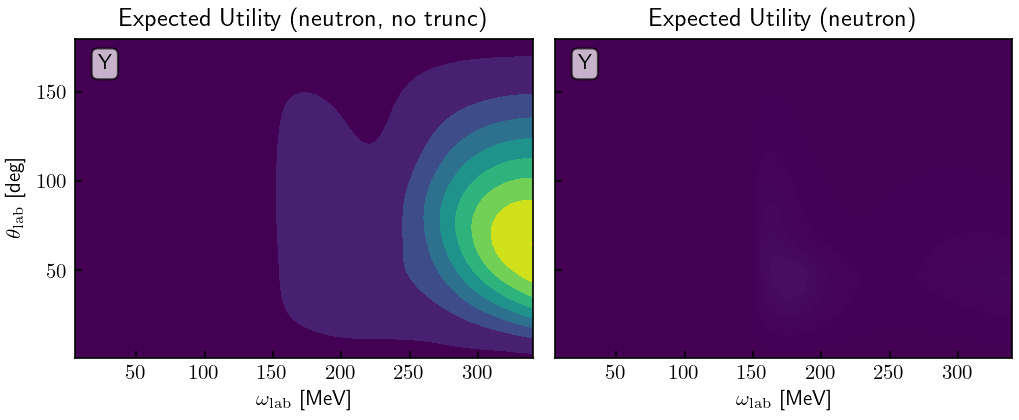

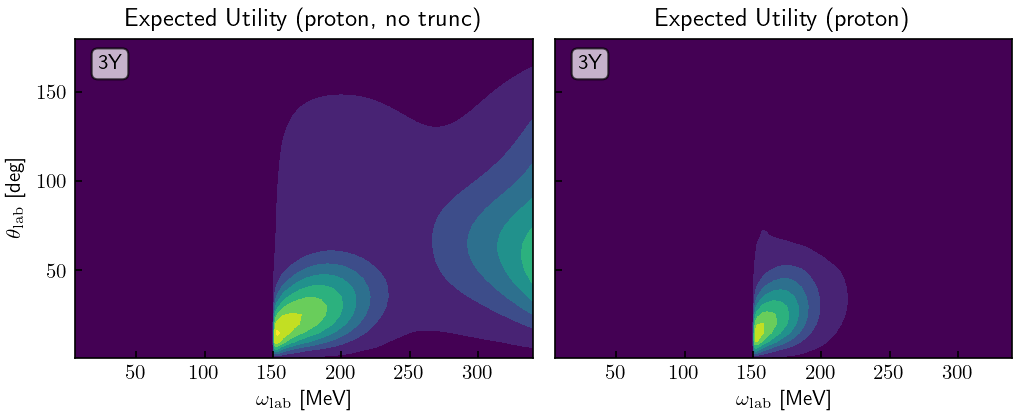

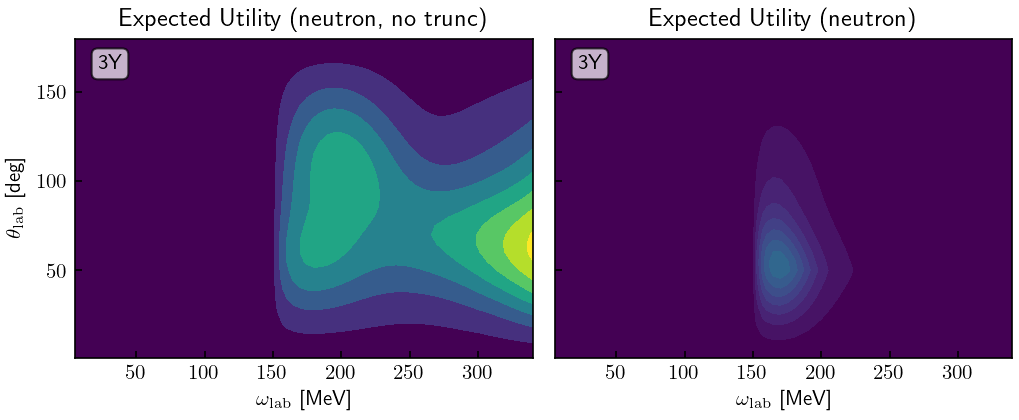

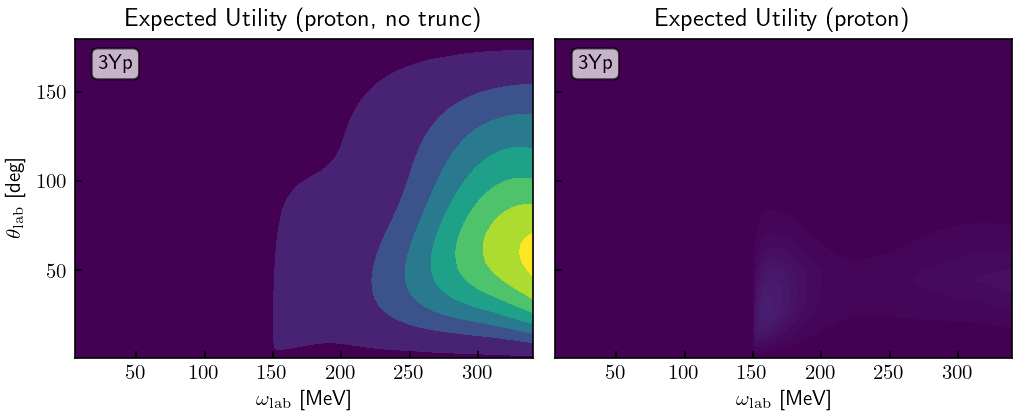

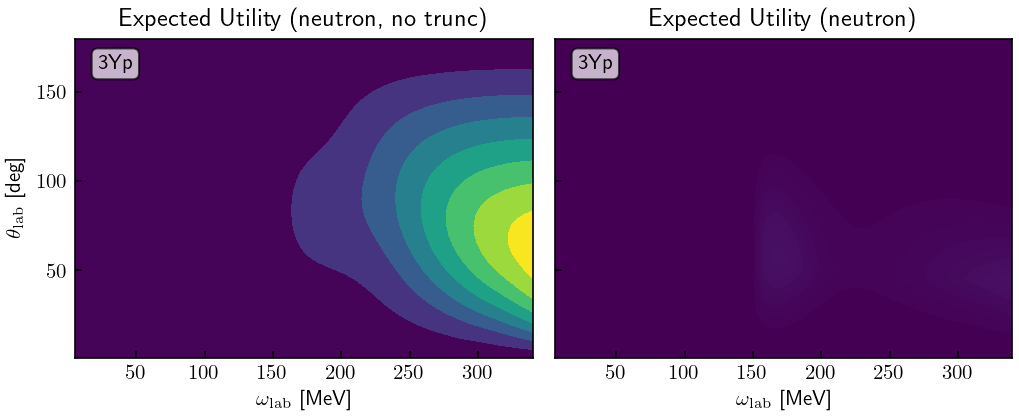

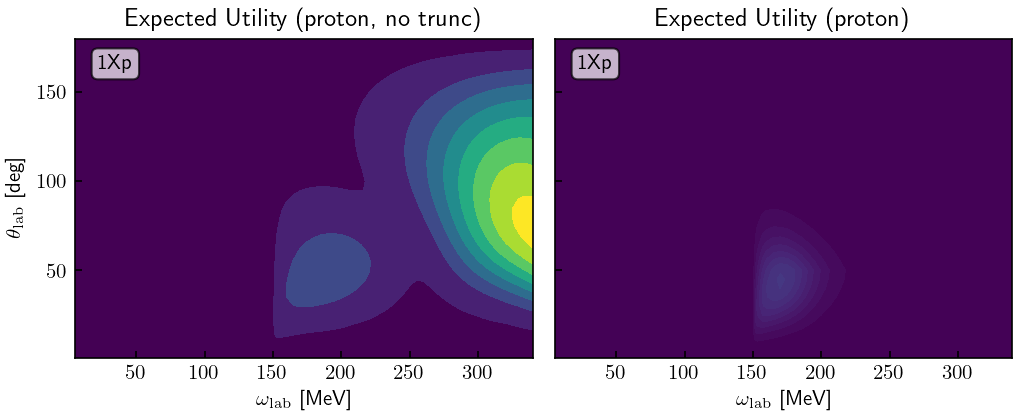

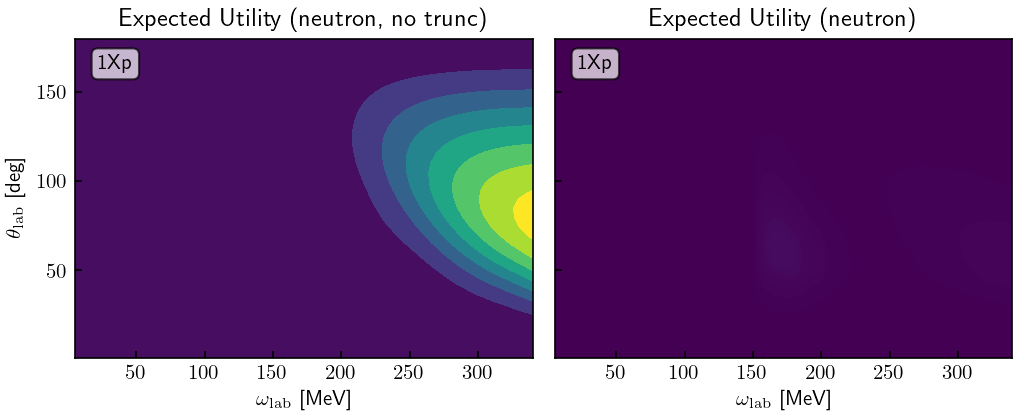

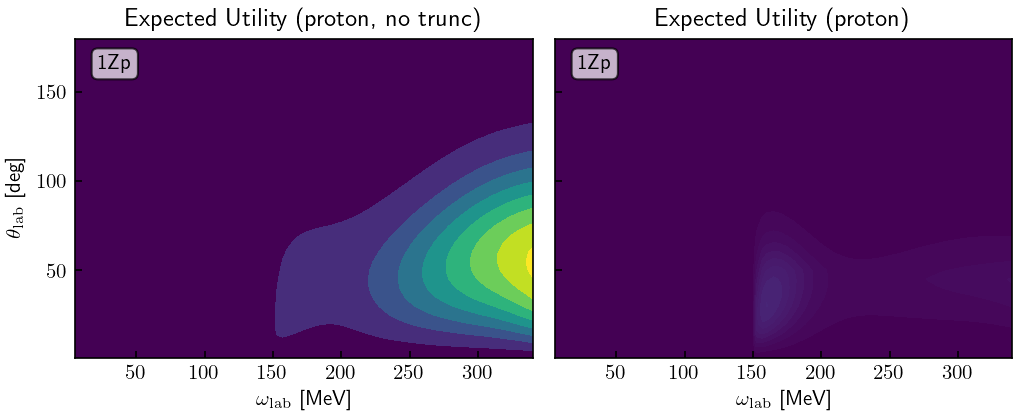

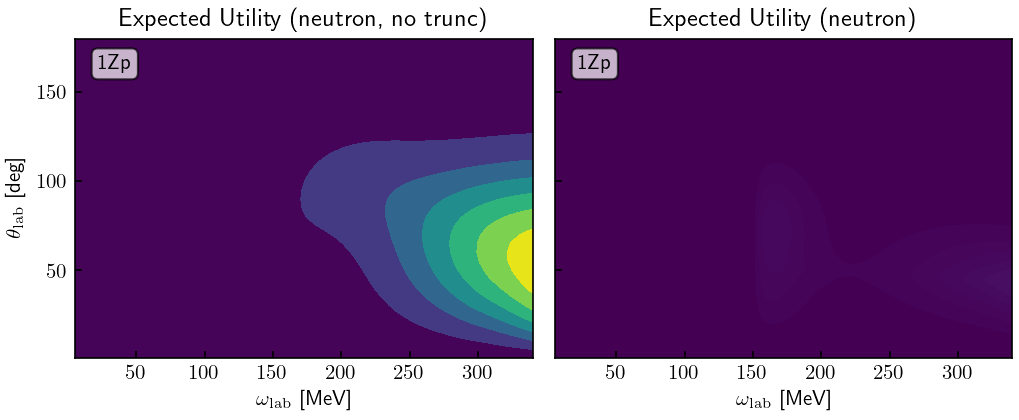

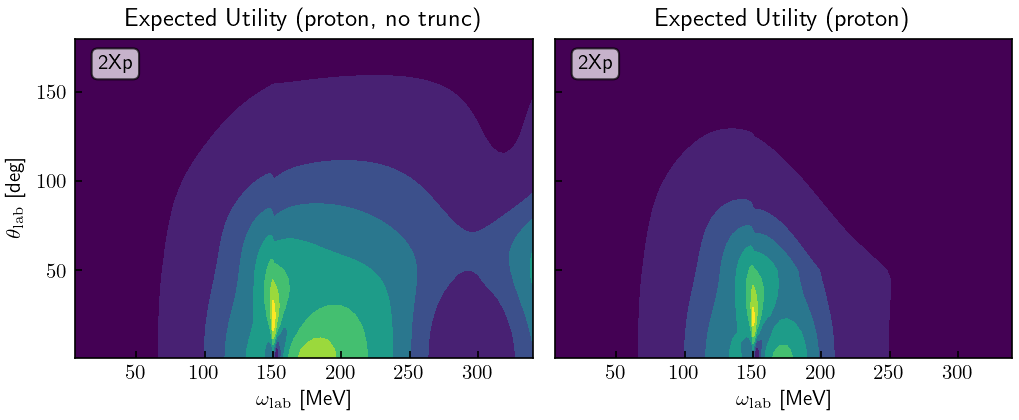

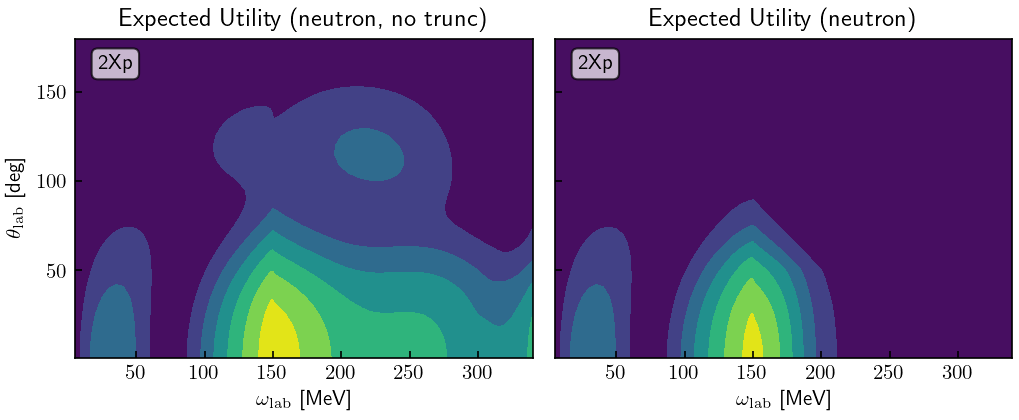

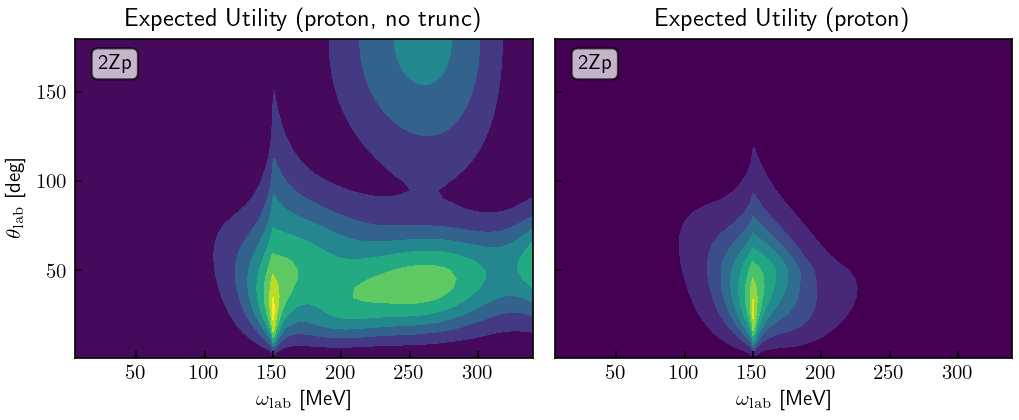

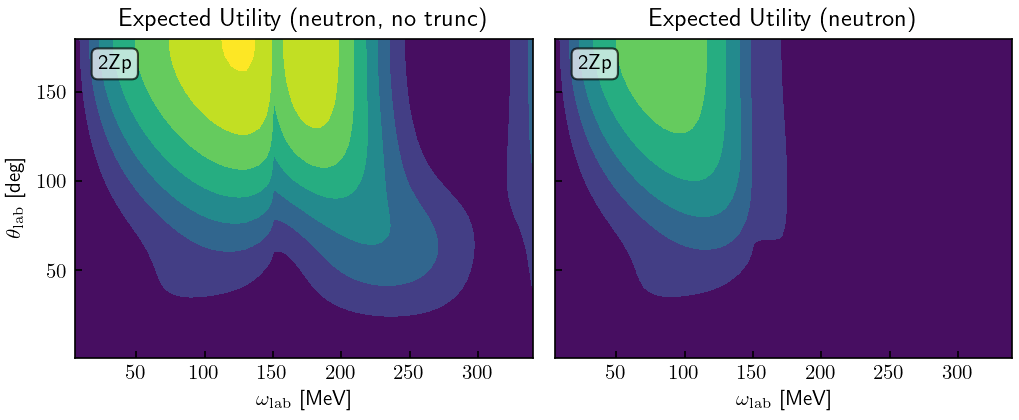

In [64]:
for i, obs_i in enumerate(observables_unique):
    for j, nucleon_j in enumerate(['proton', 'neutron']):
        fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
        
        util_no_trunc = util_dict_no_trunc[obs_i, nucleon_j]
        util_trunc = util_dict_trunc[obs_i, nucleon_j]
        util_max = np.max([util_no_trunc, util_trunc])
        util_min = np.min([util_no_trunc, util_trunc])
#         plt.contourf()
        axes[0].contourf(
            omega_lab_unique, degrees_lab_unique, util_no_trunc.reshape(n_omega, n_angle).T,
            vmin=util_min, vmax=util_max,
        )
        axes[0].set_title(f'Expected Utility ({nucleon_j}, no trunc)')
        axes[1].contourf(
            omega_lab_unique, degrees_lab_unique, util_trunc.reshape(n_omega, n_angle).T,
            vmin=util_min, vmax=util_max,
        )
        axes[1].set_title(f'Expected Utility ({nucleon_j})')
        axes[0].set_ylabel(r'$\theta_{\mathrm{lab}}$ [deg]')
        text = obs_i
        if obs_i == 'crosssection':
            text = 'dsg'
        for ax in axes:
            ax.text(
                0.05, 0.95, text, transform=ax.transAxes,
                bbox=dict(facecolor='w', boxstyle='round', alpha=0.7), ha='left', va='top')

            ax.set_xlabel(r'$\omega_{\mathrm{lab}}$ [MeV]')
            ax.tick_params(direction='in')
        fig.tight_layout()
        fig.savefig(f'figures/utility_trunc_vs_no_trunc_obs-{obs_i}_nucleon-{nucleon_j}.pdf')
#         plt.close()

In [75]:
from matplotlib import ticker

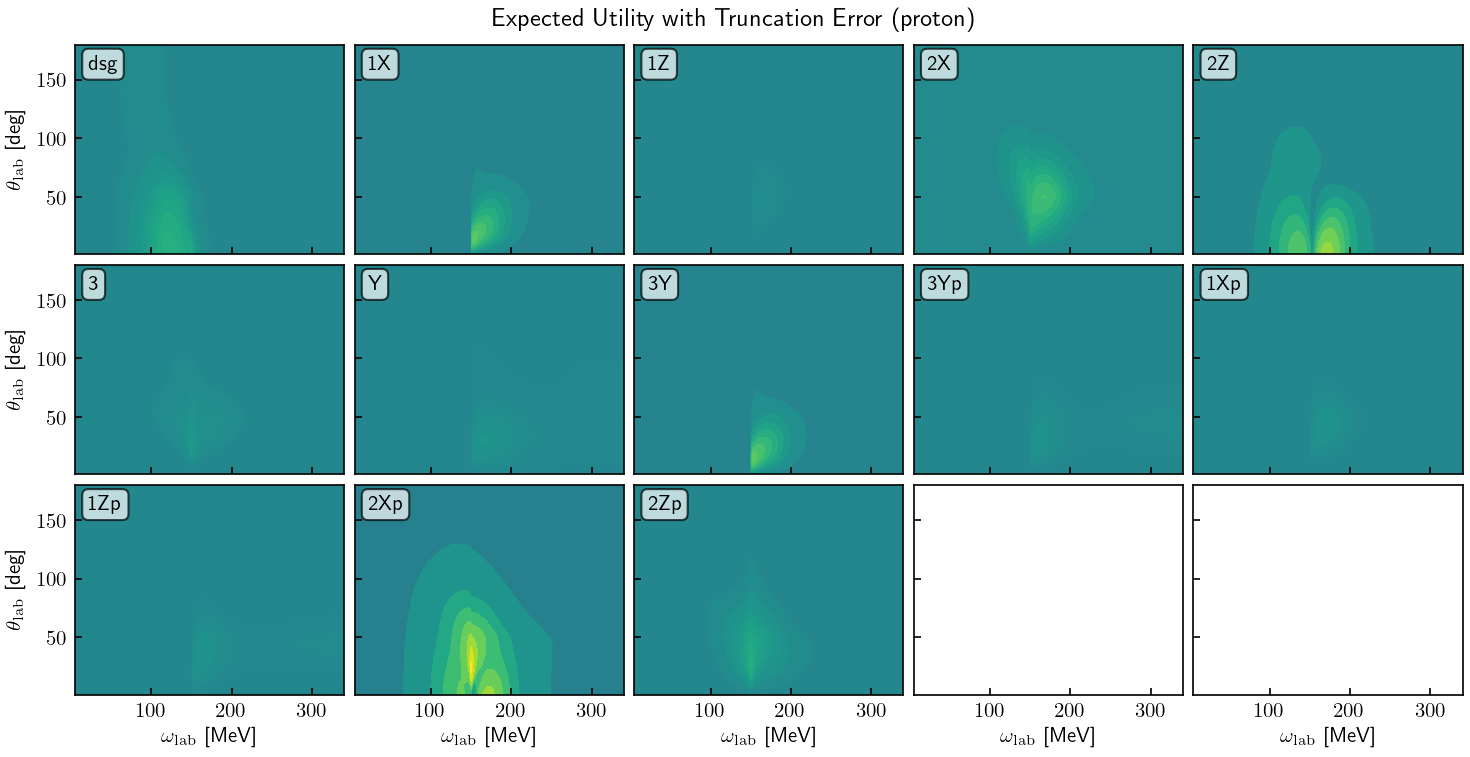

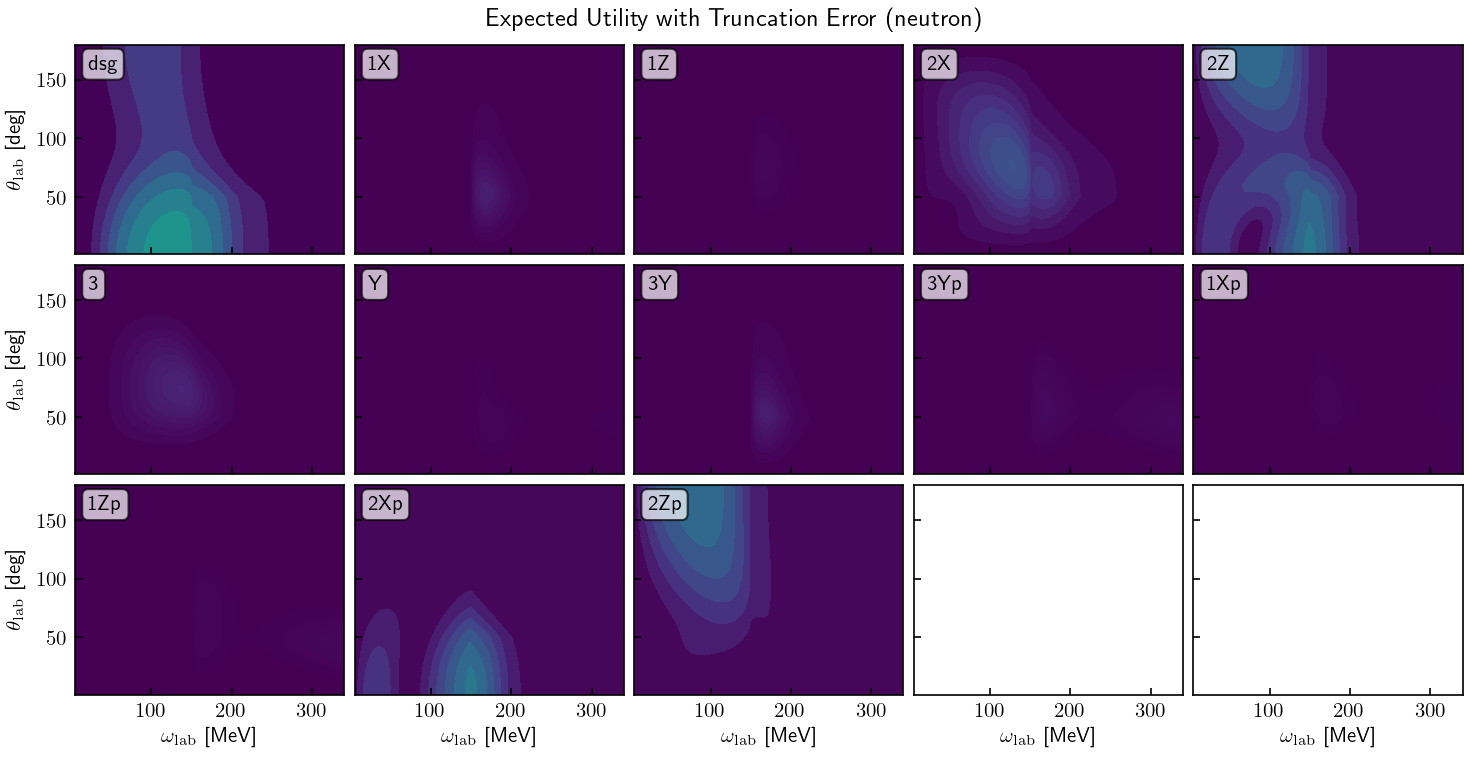

In [85]:
for j, nucleon_j in enumerate(['proton', 'neutron']):
#     utils_j = [util_i for (o, n), util_i in util_dict_trunc.items() if n == nucleon_j]
    utils_j = [util_i for (o, n), util_i in util_dict_trunc.items()]
    util_max = np.max(utils_j)
    util_min = np.min(utils_j)
    
    fig, axes = plt.subplots(3, 5, figsize=(10, 5), sharex=True, sharey=True)
    fig.suptitle(f'Expected Utility with Truncation Error ({nucleon_j})', y=1.02)
    for i, obs_i in enumerate(observables_unique):
        ax = axes.ravel()[i]
        util_trunc = util_dict_trunc[obs_i, nucleon_j]
#         plt.contourf()
#         ax.contourf(
#             omega_lab_unique, degrees_lab_unique, util_trunc.reshape(n_omega, n_angle).T - util_min + 1e-5,
#             vmin=1e-5, vmax=util_max-util_min + 1e-5, #locator=ticker.LogLocator(),
#         )
        ax.contourf(
            omega_lab_unique, degrees_lab_unique, util_trunc.reshape(n_omega, n_angle).T,
            vmin=util_min, vmax=util_max,
        )
        
        ax.set_ylabel(r'$\theta_{\mathrm{lab}}$ [deg]')
        text = obs_i
        if obs_i == 'crosssection':
            text = 'dsg'
        ax.text(
            0.05, 0.95, text, transform=ax.transAxes,
            bbox=dict(facecolor='w', boxstyle='round', alpha=0.7), ha='left', va='top')
    
    for ax in axes.flat:
        ax.set_xlabel(r'$\omega_{\mathrm{lab}}$ [MeV]')
        ax.tick_params(direction='in')
        ax.label_outer()
    fig.tight_layout(w_pad=0.5, h_pad=0.5)
    fig.savefig(f'figures/utility_trunc_all-obs_nucleon-{nucleon_j}.pdf')